<a href="https://colab.research.google.com/github/OritPa/ML_TripAdvisor_Pipeline/blob/main/Missings_and_Outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [2]:
sns.set_style("whitegrid")

In [3]:
with open('df_after_eda.pkl', 'rb') as file:
    df = pickle.load(file)

In [4]:
print("Rows, Cols:", df.shape)

Rows, Cols: (224763, 63)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224763 entries, 0 to 224762
Data columns (total 63 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   restaurant_link                    224763 non-null  string 
 1   restaurant_name                    224763 non-null  string 
 2   region                             224763 non-null  string 
 3   province                           224763 non-null  string 
 4   city                               224763 non-null  string 
 5   address                            224763 non-null  string 
 6   latitude                           222603 non-null  float64
 7   longitude                          222603 non-null  float64
 8   claimed                            224763 non-null  int64  
 9   awards                             224763 non-null  int64  
 10  popularity_detailed                208339 non-null  string 
 11  popularity_generic                 2074

In [6]:
# Basic missingness overview
missing_summary = (
    df.isnull().sum()
    .to_frame("missing_count")
    .assign(
        missing_percent=lambda x: (x["missing_count"] / len(df) * 100).round(2),
        dtype=df.dtypes.astype(str).values
    )
    .sort_values("missing_percent", ascending=False)
)

missing_summary.head(40)


,missing_count,missing_percent,dtype
price_range,161650,71.92,string
max_price,161650,71.92,float64
atmosphere,151722,67.50,float64
special_diets,144155,64.14,string
working_shifts_per_week,106497,47.38,float64
open_hours_per_week,106497,47.38,float64
open_days_per_week,106497,47.38,float64
food,89308,39.73,float64
value,89085,39.64,float64
service,88931,39.57,float64


<Figure size 1200x600 with 0 Axes>

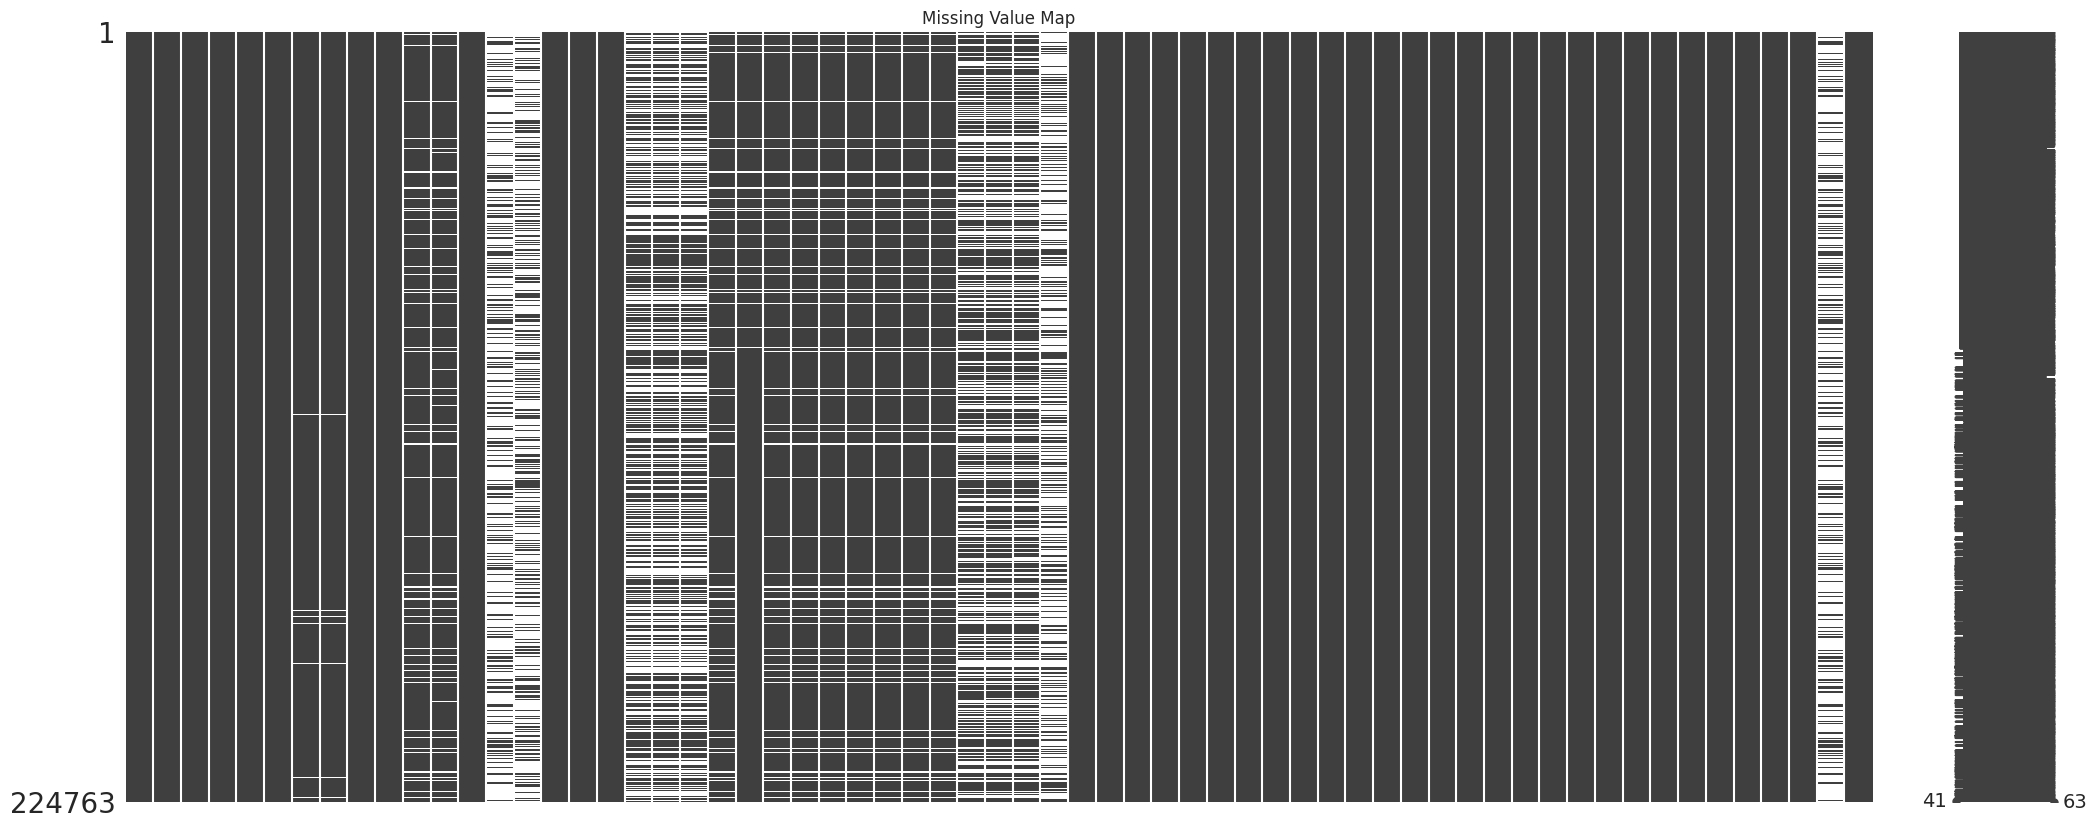

In [7]:

plt.figure(figsize=(12,6))
msno.matrix(df)
plt.title("Missing Value Map")
plt.show()


#MISSING-DATA HANDLING & MODEL DF CREATION

###Definitions

In [8]:
# Features to drop later due to leakage with target or redundancy
RATING_COLS = ["excellent","very_good","average","poor","terrible"]
EXP_COLS    = ["food","service","value","atmosphere"]
LEAKAGE_COLS = RATING_COLS + EXP_COLS + ["avg_rating","total_reviews_count","reviews_count_in_default_language"]

# High-correlation duplicates to remove (keep cuisines__*, drop top_tags__* pairs)
DUPLICATE_SEMANTICS_DROP = ["top_tags__italian","top_tags__pizza","top_tags__seafood", "top_tags__mediterranean"]

# KNN impute together (correlated operational metrics)
KNN_NUM_COLS = ["open_hours_per_week","open_days_per_week","working_shifts_per_week"]

# Simple categorical fills for columns you might actually keep
CAT_SIMPLE_FILL = {
    "default_language": "All languages",
    "popularity_detailed": "Unknown",
    "popularity_generic": "Unknown",
    "special_diets": "Unknown"

}

# Optional: impute coords from city median
IMPUTE_COORDS_BY_CITY = True

###Helpers

In [9]:
def mode_or_nan(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else np.nan

def print_missing(title, df, cols=None, topn=20):
    m = (df[cols].isna().mean()*100 if cols else df.isna().mean()*100).sort_values(ascending=False)
    print(f"\n[{title}] missing % (top {topn})")
    display(m.head(topn))


###KNN imputation for operational metrics

In [10]:
knn_cols = [c for c in KNN_NUM_COLS if c in df.columns]
if knn_cols:
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    df[knn_cols] = imputer.fit_transform(df[knn_cols])


###Coords impute by city, province median

In [11]:
#Fill coord nased on city and province
if IMPUTE_COORDS_BY_CITY and {"city","province","latitude","longitude"}.issubset(df.columns):
    df["latitude"]  = df.groupby(["city","province"])["latitude"].transform(lambda x: x.fillna(x.median()))
    df["longitude"] = df.groupby(["city","province"])["longitude"].transform(lambda x: x.fillna(x.median()))

### max_price and price_range

In [12]:
# Fill based on price_level
df['max_price'] = df['max_price'].fillna(
    df.groupby('price_level')['max_price'].transform('median')
)

In [13]:
df['max_price'].describe()

,max_price
count,224763.000000
mean,27.628364
std,20.204160
min,1.000000
25%,13.000000
50%,30.000000
75%,30.000000
max,999.000000


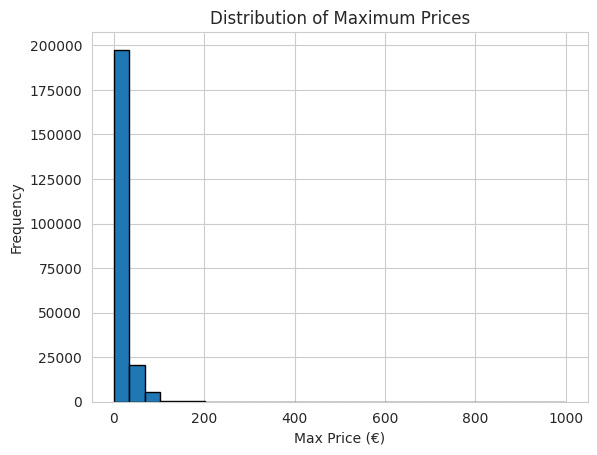

In [14]:
#New distribution of Max_Price
plt.hist(df['max_price'], bins=30, edgecolor='black')
plt.title('Distribution of Maximum Prices')
plt.xlabel('Max Price (€)')
plt.ylabel('Frequency')
plt.show()

In [15]:
#Because data is skewed and after missing treatment there is a slight change in mean and distribution, better to change bins in price_range to accomodate the new data
bins = [0, 15, 25, 40, 70, np.inf]
labels = ['0–15', '15–25', '25–40', '40–70', '>70']
df['price_range'] = pd.cut(df['max_price'], bins=bins, labels=labels, right=True)

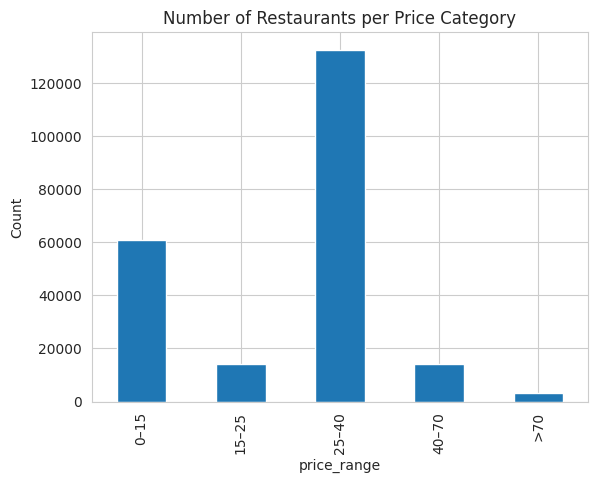

In [16]:
df['price_range'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Restaurants per Price Category')
plt.ylabel('Count')
plt.show()

In [17]:
df['price_range'].value_counts(normalize=True).sort_index()

,proportion
price_range,
0–15,0.270374
15–25,0.062688
25–40,0.589973
40–70,0.062408
>70,0.014558


###Simple categorical fills

In [18]:
for col, fill_val in CAT_SIMPLE_FILL.items():
    if col in df.columns:
        df[col] = df[col].fillna(fill_val)


### After missing treatment

In [19]:
#Later dropped cols were not treated
missing_summary = (
    df.isnull().sum()
    .to_frame("missing_count")
    .assign(
        missing_percent=lambda x: (x["missing_count"] / len(df) * 100).round(2),
        dtype=df.dtypes.astype(str).values
    )
    .sort_values("missing_percent", ascending=False)
)

missing_summary.head(20)

,missing_count,missing_percent,dtype
atmosphere,151722,67.50,float64
food,89308,39.73,float64
value,89085,39.64,float64
service,88931,39.57,float64
avg_rating,16708,7.43,float64
terrible,16390,7.29,float64
reviews_count_in_default_language,16390,7.29,float64
poor,16390,7.29,float64
average,16390,7.29,float64
very_good,16390,7.29,float64


In [20]:
with open('df_after_missing.pkl', 'wb') as f:
    pickle.dump(df, f)

print("df_after_missing dataset saved as a pickle file.")

df_after_missing dataset saved as a pickle file.


#Outliers

In [21]:
with open('df_after_missing.pkl', 'rb') as file:
    df = pickle.load(file)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224763 entries, 0 to 224762
Data columns (total 63 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   restaurant_link                    224763 non-null  string  
 1   restaurant_name                    224763 non-null  string  
 2   region                             224763 non-null  string  
 3   province                           224763 non-null  string  
 4   city                               224763 non-null  string  
 5   address                            224763 non-null  string  
 6   latitude                           224763 non-null  float64 
 7   longitude                          224763 non-null  float64 
 8   claimed                            224763 non-null  int64   
 9   awards                             224763 non-null  int64   
 10  popularity_detailed                224763 non-null  string  
 11  popularity_generic        

###Definitions

In [23]:
RATING_COLS = ["excellent","very_good","average","poor","terrible"]
EXP_COLS    = ["food","service","value","atmosphere"]
LEAKAGE_COLS = RATING_COLS + EXP_COLS + ["avg_rating","total_reviews_count","reviews_count_in_default_language"]

# High-correlation duplicates to remove (keep cuisines__*, drop top_tags__* pairs later)
DUPLICATE_SEMANTICS_DROP = ["top_tags__italian","top_tags__pizza","top_tags__seafood", "top_tags__mediterranean"]

# Columns you plan to drop before modeling (we'll skip these during outlier handling)
LATER_DROP_COLS = [c for c in (LEAKAGE_COLS + DUPLICATE_SEMANTICS_DROP) if c in df.columns]

# Optional: columns to *always* skip (IDs, coordinates, etc.)
ALWAYS_SKIP_COLS = [c for c in ["latitude","longitude"] if c in df.columns]

# Whether to ignore “later dropped” columns in the outlier step
IGNORE_LATER_DROP = True

# IQR factor (1.5 is standard)
IQR_FACTOR = 1.5

# Visualization limits
MAX_BOXPLOTS = 18      # to avoid giant grid; adjust as needed
HIST_BINS    = 40

print("Columns flagged to be dropped before modeling (skipped here):")
print(LATER_DROP_COLS)

Columns flagged to be dropped before modeling (skipped here):
['excellent', 'very_good', 'average', 'poor', 'terrible', 'food', 'service', 'value', 'atmosphere', 'avg_rating', 'total_reviews_count', 'reviews_count_in_default_language', 'top_tags__italian', 'top_tags__pizza', 'top_tags__seafood', 'top_tags__mediterranean']


In [24]:
#Snapshot BEFORE
df_before = df.copy()

###Build numeric frame (exclude binary + skip lists

In [25]:
df_num = df.select_dtypes(include=["int64","float64","float32"]).copy()

# Exclude binary/dummy columns (0/1 or 2 unique values incl. NaN)
binary_cols = [c for c in df_num.columns if df_num[c].dropna().nunique() <= 2]

# Columns to skip from outlier handling
skip_cols = set(binary_cols) | set(ALWAYS_SKIP_COLS)
if IGNORE_LATER_DROP:
    skip_cols |= set(LATER_DROP_COLS)

num_cols_to_cap = [c for c in df_num.columns if c not in skip_cols]

print("\nExcluded binary columns:", sorted(list(set(binary_cols))))
print("Explicitly skipped cols:", sorted(list(set(skip_cols) - set(binary_cols))))
print("Numeric columns to cap:", len(num_cols_to_cap))


Excluded binary columns: ['awards', 'claimed', 'cuisines__bar', 'cuisines__italian', 'cuisines__mediterranean', 'cuisines__other', 'cuisines__pizza', 'cuisines__seafood', 'features__other', 'features__reservations', 'features__seating', 'features__serves alcohol', 'features__table service', 'features__takeout', 'features__wheelchair accessible', 'gluten_free', 'is_michelin', 'meals_after-hours', 'meals_breakfast', 'meals_brunch', 'meals_dinner', 'meals_drinks', 'meals_lunch', 'target', 'top_tags__cheap eats', 'top_tags__italian', 'top_tags__mediterranean', 'top_tags__mid-range', 'top_tags__other', 'top_tags__pizza', 'top_tags__seafood', 'vegan_options', 'vegetarian_friendly']
Explicitly skipped cols: ['atmosphere', 'average', 'avg_rating', 'excellent', 'food', 'latitude', 'longitude', 'poor', 'reviews_count_in_default_language', 'service', 'terrible', 'total_reviews_count', 'value', 'very_good']
Numeric columns to cap: 5


###IQR capping (in place on df)

In [26]:
def iqr_cap_inplace(df_source, cols, factor=1.5):
    """
    Caps values outside [Q1 - factor*IQR, Q3 + factor*IQR] to the boundary.
    Returns a small report with % of values capped per column.
    """
    report = []
    for col in cols:
        s = df_source[col]
        if s.isna().all():
            report.append({"column": col, "capped_pct": 0.0, "lower": np.nan, "upper": np.nan})
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - factor*iqr, q3 + factor*iqr
        before = s.values.copy()
        s_clipped = s.clip(lower, upper)
        df_source[col] = s_clipped
        capped = np.mean(before != s_clipped.values) * 100.0
        report.append({"column": col, "capped_pct": capped, "lower": float(lower), "upper": float(upper)})
    return pd.DataFrame(report).sort_values("capped_pct", ascending=False)

cap_report = iqr_cap_inplace(df, num_cols_to_cap, factor=IQR_FACTOR)
print("\nIQR capping report (top 15 by % capped):")
display(cap_report.head(15).round(3))




IQR capping report (top 15 by % capped):


,column,capped_pct,lower,upper
1,open_days_per_week,28.715,5.566,6.723
2,open_hours_per_week,27.297,34.321,76.132
3,working_shifts_per_week,19.067,4.745,10.759
4,max_price,3.990,-12.500,55.500
0,price_level,0.000,-0.500,3.500


### Boxplots AFTER (subset to first N to keep tidy)

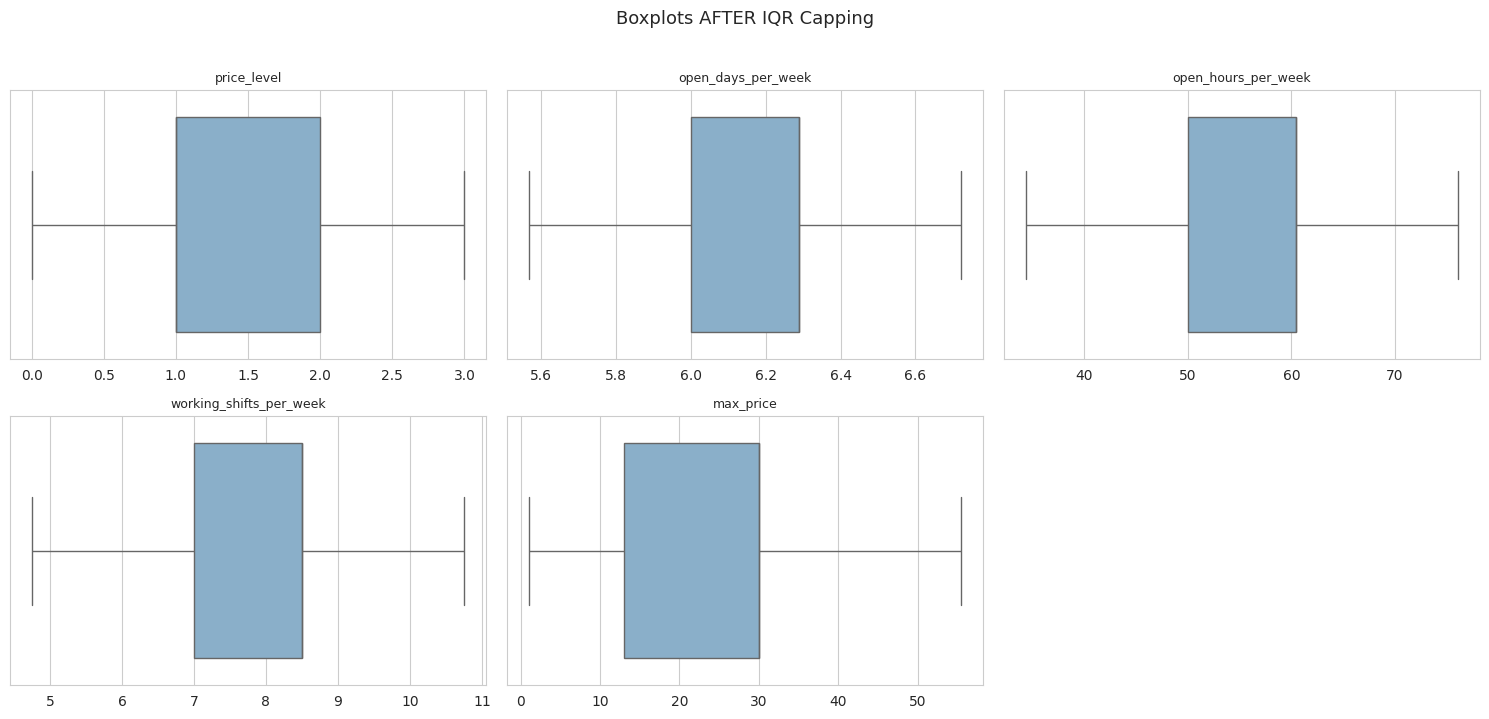

In [27]:
def boxplots_after(df_num_like, ncols=3, title="Boxplots AFTER IQR Capping", max_plots=18):
    cols = df_num_like.columns.tolist()[:max_plots]
    nrows = int(np.ceil(len(cols) / ncols)) if cols else 1
    plt.figure(figsize=(5*ncols, 3.5*nrows))
    for i, col in enumerate(cols, 1):
        plt.subplot(nrows, ncols, i)
        sns.boxplot(x=df_num_like[col], color="#80b1d3", fliersize=2)
        plt.title(col, fontsize=9)
        plt.xlabel("")
    plt.suptitle(title, fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

boxplots_after(df[num_cols_to_cap], max_plots=MAX_BOXPLOTS)

###Before vs After histograms (for most-affected columns)

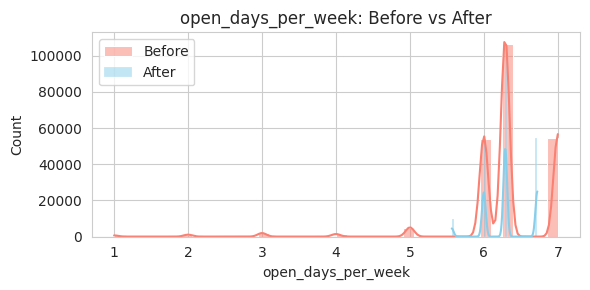

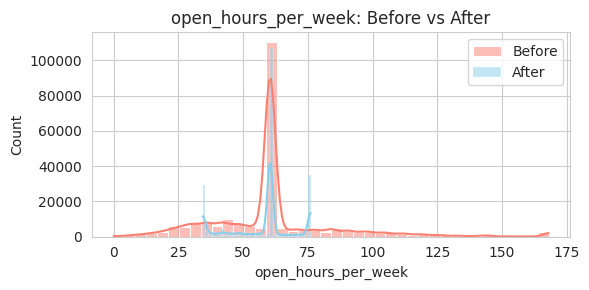

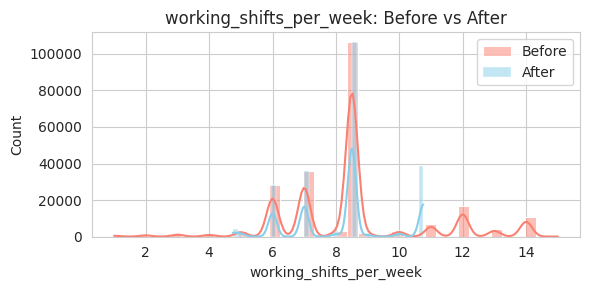

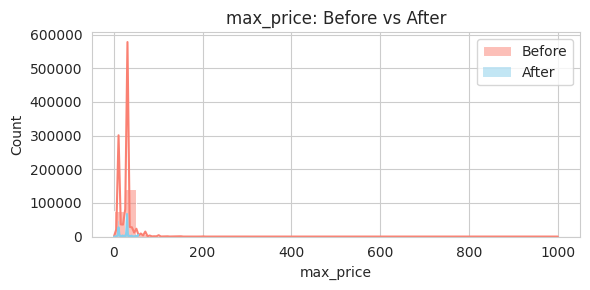

In [28]:
most_changed = cap_report.query("capped_pct > 0").head(6)["column"].tolist()
if most_changed:
    for col in most_changed:
        plt.figure(figsize=(6,3))
        sns.histplot(df_before[col], bins=HIST_BINS, color="salmon", label="Before", kde=True)
        sns.histplot(df[col],       bins=HIST_BINS, color="skyblue", label="After",  kde=True)
        plt.title(f"{col}: Before vs After")
        plt.legend()
        plt.tight_layout()
        plt.show()

###Summary before/after

In [29]:
def summary_before_after(df_before, df_after, cols):
    summary = pd.DataFrame({
        "column": cols,
        "mean_before":  [df_before[c].mean() for c in cols],
        "mean_after":   [df_after[c].mean()  for c in cols],
        "std_before":   [df_before[c].std()  for c in cols],
        "std_after":    [df_after[c].std()   for c in cols],
        "p01_before":   [df_before[c].quantile(0.01) for c in cols],
        "p01_after":    [df_after[c].quantile(0.01)  for c in cols],
        "p99_before":   [df_before[c].quantile(0.99) for c in cols],
        "p99_after":    [df_after[c].quantile(0.99)  for c in cols],
    })
    summary["mean_change_pct"] = (
        100 * (summary["mean_after"] - summary["mean_before"]) /
        summary["mean_before"].replace(0, np.nan)
    )
    return summary.round(3)

summary_iqr = summary_before_after(df_before, df, num_cols_to_cap)
print("\nSummary of before/after (top 20 by |mean_change_pct|):")
display(summary_iqr.reindex(summary_iqr["mean_change_pct"].abs().sort_values(ascending=False).index).head(20))



Summary of before/after (top 20 by |mean_change_pct|):


,column,mean_before,mean_after,std_before,std_after,p01_before,p01_after,p99_before,p99_after,mean_change_pct
2,open_hours_per_week,60.453,57.474,24.342,12.838,12.0,34.321,167.883,76.132,-4.927
4,max_price,27.628,26.356,20.204,11.493,7.0,7.000,90.000,55.500,-4.604
3,working_shifts_per_week,8.503,8.240,2.218,1.557,3.0,4.745,14.000,10.759,-3.099
1,open_days_per_week,6.289,6.294,0.680,0.298,3.0,5.566,7.000,6.723,0.077
0,price_level,1.289,1.289,0.856,0.856,0.0,0.000,3.000,3.000,0.000


###Correlation shift check

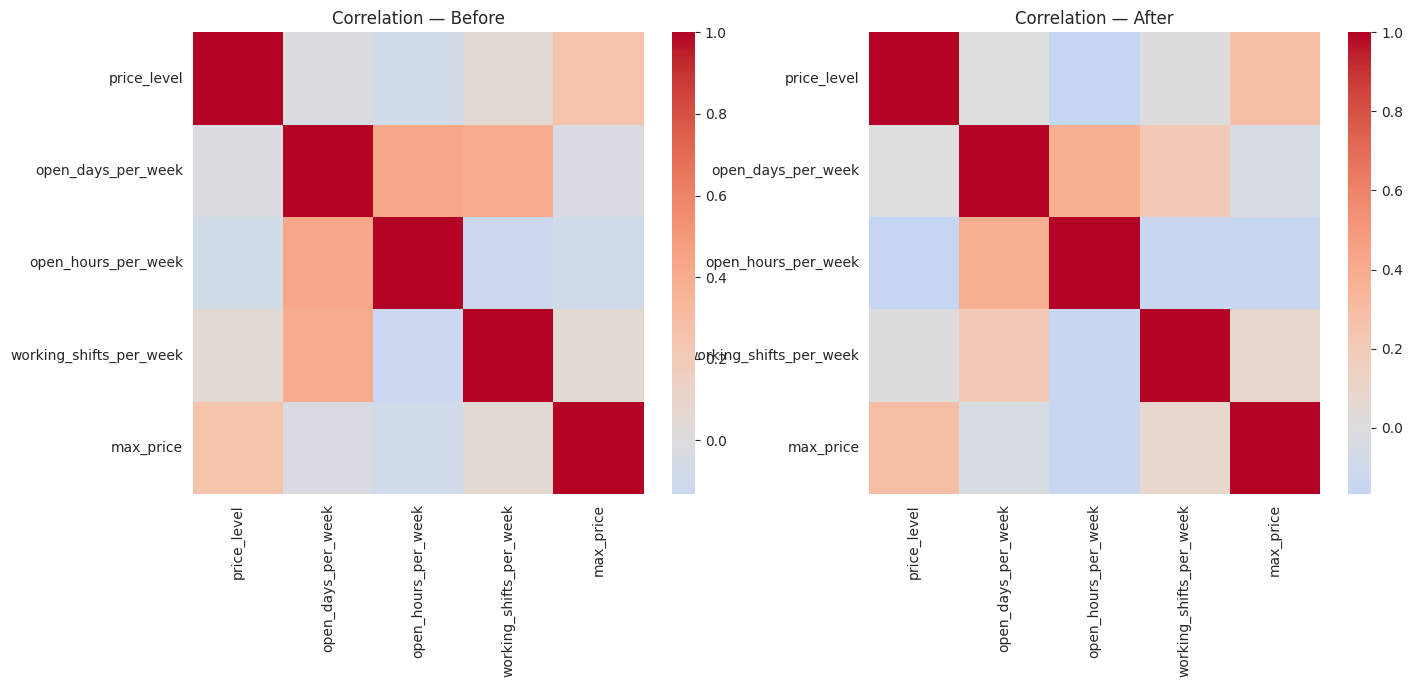

Average correlation shift (across capped set): 0.0416


In [30]:
if len(num_cols_to_cap) >= 2:
    corr_before = df_before[num_cols_to_cap].corr()
    corr_after  = df[num_cols_to_cap].corr()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(corr_before, cmap="coolwarm", center=0, ax=axes[0])
    axes[0].set_title("Correlation — Before")
    sns.heatmap(corr_after,  cmap="coolwarm", center=0, ax=axes[1])
    axes[1].set_title("Correlation — After")
    plt.show()

    corr_diff = (corr_after - corr_before).abs().mean().mean()
    print(f"Average correlation shift (across capped set): {corr_diff:.4f}")

###Potential drop candidates (info only)

In [31]:
low_var_cols = [c for c in num_cols_to_cap if df[c].nunique() <= 2]
high_na_cols = [c for c in df.columns if df[c].isna().mean() > 0.90]
drop_candidates = sorted(set(low_var_cols + high_na_cols))
print("\nPotential drop columns (low-var or >90% NA):")
print(drop_candidates)

print("\nOutlier handling complete.")


Potential drop columns (low-var or >90% NA):
[]

Outlier handling complete.


In [32]:
out_dir = "eda_reports"
os.makedirs(out_dir, exist_ok=True)

# 1) Save the detailed capping report
cap_path_csv = os.path.join(out_dir, "iqr_capping_report.csv")
cap_report.to_csv(cap_path_csv, index=False)
print(f"Saved: {cap_path_csv}  (rows={len(cap_report)})")

# 2) Save the before/after stats summary (means, stds, p01/p99, % change)
sum_path_csv = os.path.join(out_dir, "iqr_before_after_summary.csv")
summary_iqr.to_csv(sum_path_csv, index=False)
print(f"Saved: {sum_path_csv}  (rows={len(summary_iqr)})")

# 3) (Optional) also save the list of numeric columns we actually capped
cols_path_txt = os.path.join(out_dir, "numeric_columns_capped.txt")
with open(cols_path_txt, "w") as f:
    for c in num_cols_to_cap:
        f.write(f"{c}\n")
print(f"Saved: {cols_path_txt}  (count={len(num_cols_to_cap)})")



Saved: eda_reports/iqr_capping_report.csv  (rows=5)
Saved: eda_reports/iqr_before_after_summary.csv  (rows=5)
Saved: eda_reports/numeric_columns_capped.txt  (count=5)


In [33]:
with open('df_after_outliers.pkl', 'wb') as f:
    pickle.dump(df, f)

print("df_after_outliers dataset saved as a pickle file.")

df_after_outliers dataset saved as a pickle file.
